# Deep MicroBiome

Aug. 14. 2019
@ Youngwon (youngwon08@gmail.com)

In [1]:
import os
import json
import numpy as np
import pandas as pd
import copy
import logging
import sys
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

import configuration
from loss_and_metric import metric_test, metric_texa_test
import readers
import build_network
import configuration
from utils import file_path_fold, plot_history

/DATA/home/muha/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras.backend as k

config = k.tf.ConfigProto()
config.gpu_options.allow_growth=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
k.set_session(k.tf.Session(config=config))

In [4]:
logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

## Pick Models

In [5]:
# %%bash
# ls

In [6]:
save = False
kfold=30
network_model_keys = ['optimizer','lr','decay']
architecture_keys = ['weight_decay', 'weight_l1_penalty', #'weight_l2_penalty',
                     'tree_thrd', 'weight_initial',
                     'batch_normalization','drop_out']
network_training_keys = ['batch_size','epochs']

In [7]:
########################################################################

filenames = 'fev1.Rmd'
models = [
          'realdata_fev1/fev1_deep',
          'realdata_fev1/fev1_deep_l1',
          'realdata_fev1/fev1_deepbiome',
#           'realdata_fev1/fev1_deepbiome_l1',
# #           'realdata_fev1/fev1_deepbiome_wo_noise',
# #           'realdata_fev1/fev1_deepbiome_noise_decay',
         ]

models_aka = [
          'DNN',
          'DNN+l1',
          'DeepBiome',
#           'DeepBiome+l1',
# #           'deepbiome_wo_noise',
# #           'deepbiome_noise_decay',
         ]
num_classes = 0

########################################################################

In [8]:
model_network_info = {}
model_path_info = {}
for model_path in models:
    config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
    config_data.set_config_map(config_data.get_section_map())
    config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
    config_network.set_config_map(config_network.get_section_map())

    model_path_info[model_path] = config_data.get_config_map()
    model_network_info[model_path] = config_network.get_config_map()

In [9]:
if num_classes == 0: y_names = ['loss','correlation_coefficient']
elif num_classes==1: y_names = ['loss','binary_accuracy','sensitivity','specificity','gmeasure', 'auc']
else: y_names=['loss','categorical_accuracy','precision','recall','f1', 'auc']

if num_classes == 0: measure_index = np.array([0,1])
elif num_classes==1: measure_index = np.array([2,3,4,1,5])
else: measure_index = np.array([1,2,3,4,5])

## History

#### per Epochs

In [10]:
# fig = plot_history(models, models_aka=models_aka, history_types = ['validation','train'], 
#          y_names = y_names, x_name='epochs', mode='summary')
# if save: fig.savefig('%s/%s.png' % (fig_dir, 'hist'), pad_inches=0.01)
# fig.show()

#### per Iterations

In [11]:
# fig = plot_history(models, models_aka=models_aka,
#              history_types = ['validation','train'], 
#              y_names = ['binary_accuracy','sensitivity','specificity','gmeasure'], x_name='iterations', niters=niters)
# if save: fig.savefig('%s/%s.png' % (fig_dir, 'hist'), pad_inches=0.01)
# fig.show()

## Accuracy

In [12]:
results = []
# log.info('%20s & %s' % ('model', '& '.join(['%s ' % name for name in np.array(y_names)[[measure_index]]])))
print('%20s & %s \\\\\ \hline' % ('model', '& '.join(['%s ' % name for name in np.array(y_names)[[measure_index]]])))
# for model, aka in zip(models, models_aka):
#     evaluation = np.load('%s/eval.npy' % model)
#     log.info('%20s: %s' % (aka, ''.join(['%10.4f (%10.4f)'%(mean, std) for mean, std in zip(np.mean(evaluation, axis=0),np.std(evaluation, axis=0))])))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())
for model, aka in zip(models, models_aka):
    train_evaluation = np.load('%s/train_eval.npy' % model)[:,measure_index]
    train_res = '&'.join(['%10.3f & %10.3f'%(mean, std) for mean, std in zip(np.mean(train_evaluation, axis=0),np.std(train_evaluation, axis=0))])
    test_evaluation = np.load('%s/test_eval.npy' % model)[:,measure_index]
    test_res = '&'.join(['%10.3f & %10.3f'%(mean, std) for mean, std in zip(np.mean(test_evaluation, axis=0),np.std(test_evaluation, axis=0))])
#     log.info('%s & %s & %s \\\\' % (aka, train_res, test_res))
    print('%s & %s & %s \\\\' % (aka, test_res, train_res))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())

               model & loss & correlation_coefficient  \\\ \hline
DNN &      0.244 &      0.493&     1.000 &      0.000 &      0.102 &      0.070&     0.127 &      0.192 \\
DNN+l1 &      0.281 &      0.436&     1.000 &      0.000 &      0.100 &      0.082&     0.234 &      0.275 \\
DeepBiome &      0.033 &      0.057&     1.000 &      0.000 &      0.033 &      0.006&     0.030 &      0.026 \\


In [13]:
col_names = ['model'] + architecture_keys + network_model_keys + network_training_keys
values = []
for model_path in models:
    config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
    config_data.set_config_map(config_data.get_section_map())
    config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
    config_network.set_config_map(config_network.get_section_map())

    path_info = config_data.get_config_map()
    network_info = config_network.get_config_map()
    values.append([model_path] 
                  + [network_info['architecture_info'].get(k, None) for k in architecture_keys]
                  + [network_info['model_info'].get(k, None) for k in network_model_keys]
                  + [network_info['training_info'].get(k, None) for k in network_training_keys])

if save:  
    with open('%s/%s' % (analysis_dir, filename), mode='w') as f:
        f.write('---\ntitle: "%s"\noutput: html_document\n---\n\n' % filename.split('.')[0])
        f.write('## History\n\n')
        f.write('![](../%s/%s.png)' % (fig_dir, 'hist'))
        f.write('\n\n## Performance\n\n')
        f.write('| %s | %s |\n' % (col_names[0], '|'.join([v[0] for v in values])))
        f.write('|---|'+'---|'*len(values)+'\n')
        for i, k in enumerate(y_names):
            f.write('| %s | %s |\n' % (k, '|'.join(['%2.3f (%2.3f)' % (res[i+1][0],res[i+1][1]) for res in results])))
        for i in range(1,len(col_names)):
            f.write('| %s | %s |\n' % (col_names[i], '|'.join([str(v[i]) for v in values])))

    #     f.write('\n')
    #     with open('%s/setting_info.Rmd'%analysis_dir, 'r') as f_info:
    #         lines = f_info.readlines()
    #         for l in lines:
    #             f.write(l)

# Choose Model

In [14]:
num=2
model_path = models[num]
model_aka = models_aka[num]

config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
config_data.set_config_map(config_data.get_section_map())
config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
config_network.set_config_map(config_network.get_section_map())

path_info = config_data.get_config_map()
network_info = config_network.get_config_map()

path_info['data_info']['data_path'] = '/'.join(path_info['data_info']['data_path'].split('/')[2:])
path_info['data_info']['tree_info_path'] = '/'.join(path_info['data_info']['tree_info_path'].split('/')[2:])
try: path_info['data_info']['count_list_path'] = '/'.join(path_info['data_info']['count_list_path'].split('/')[2:])
except: pass
try: path_info['data_info']['count_path'] = '/'.join(path_info['data_info']['count_path'].split('/')[2:])
except: pass
path_info['data_info']['idx_path'] = '/'.join(path_info['data_info']['idx_path'].split('/')[2:])
try: path_info['data_info']['disease_weight_path'] = '/'.join(path_info['data_info']['disease_weight_path'].split('/')[2:])
except: pass

log.info('%22s : %s' % ('model', model_path))
log.info('%22s : %s' % ('model_aka', model_aka))
for k in architecture_keys:
    log.info('%22s : %s' % (k, network_info['architecture_info'].get(k, None)))
for k in network_model_keys:
    log.info('%22s : %s' % (k, network_info['model_info'].get(k, None)))
for k in network_training_keys:
    log.info('%22s : %s' % (k, network_info['training_info'].get(k, None)))

[root    |INFO|<ipython-input-14-ce0e784f4c7b>:23]                  model : realdata_fev1/fev1_deepbiome
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:24]              model_aka : DeepBiome
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]           weight_decay : phylogenetic_tree
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]      weight_l1_penalty : None
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]              tree_thrd : None
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]         weight_initial : glorot_uniform
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]    batch_normalization : False
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:26]               drop_out : 0
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:28]              optimizer : adam
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:28]                     lr : 0.0001
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:28]                  decay : 0.0001
[root    |INFO|<ipython-input-14-ce0e784f4c7b>:30]     

In [15]:
evaluation = np.load('%s/test_eval.npy' % model_path)
log.info('\t %s'%' '.join(['%s' % name for name in y_names]))

_ = [log.info('%d fold : %s' % (i,line)) for i, line in enumerate(evaluation)]
log.info('Mean   : %s' % np.mean(evaluation, axis=0))
log.info('Std   : %s' % np.std(evaluation, axis=0))

# _ = [print('%d fold & %s \\tabularnewline' % (i, ' & '.join(['%.3f'% v for v in line]))) for i, line in enumerate(evaluation)]
# print('Mean & %s \\tabularnewline' % (' & '.join(['%.3f'% v for v in np.mean(evaluation, axis=0)])))
# print('Sd & %s \\tabularnewline' % (' & '.join(['%.3f'% v for v in np.std(evaluation, axis=0)])))

[root    |INFO|<ipython-input-15-65b4b58a34e1>:2] 	 loss correlation_coefficient
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 0 fold : [2.6272994e-04 1.0000000e+00]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 1 fold : [0.0102786 1.       ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 2 fold : [1.16048168e-05 1.00000000e+00]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 3 fold : [0.0170235 1.       ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 4 fold : [0.01068457 1.        ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 5 fold : [0.23773624 1.        ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 6 fold : [0.13694672 1.        ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 7 fold : [0.00184339 1.        ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 8 fold : [0.00286648 1.        ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 9 fold : [0.0054176 1.       ]
[root    |INFO|<ipython-input-15-65b4b58a34e1>:4] 10 fold : [0.01392506 1.       

### Test Correlation

In [16]:
reader_class = getattr(readers, network_info['model_info']['reader_class'].strip())
reader = reader_class(log, verbose=True)
idxs = np.array(pd.read_csv(path_info['data_info']['idx_path'])-1, dtype=np.int)
data_path = path_info['data_info']['data_path']
x_path = np.array(['%s/%s'%(data_path, path_info['data_info']['x_path']) for fold in range(idxs.shape[1])])
y_path = '%s/%s'%(data_path, path_info['data_info']['y_path'])

model_weight_path = './%s/%s' % (model_path, path_info['model_info']['weight'])

network_class = getattr(build_network, network_info['model_info']['network_class'].strip()) 
# network = network_class(network_info, path_info['data_info'], log, fold=0, num_classes=max(1,num_classes))
network = network_class(network_info, path_info['data_info'], log, fold=0, num_classes=num_classes)
network.model_compile()

[root    |INFO|build_network.py:507] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:508] Read phylogenetic tree information from data/genus48/genus48_dic.csv
[root    |INFO|build_network.py:512] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:513] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:518]      Genus: 48
[root    |INFO|build_network.py:518]     Family: 40
[root    |INFO|build_network.py:518]      Order: 23
[root    |INFO|build_network.py:518]      Class: 17
[root    |INFO|build_network.py:518]     Phylum: 9
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Phylogenetic_tree_dict info: ['Number', 'Phylum', 'Genus', 'Class', 'Family', 'Order']
[root    |IN

Instructions for updating:
Colocations handled automatically by placer.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
[root    |INFO|build_network.py:635] ------------------------------------------------------------------------------------------


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0         
__________

[root    |INFO|build_network.py:56] Build Network
[root    |INFO|build_network.py:57] Optimizer = adam
[root    |INFO|build_network.py:58] Loss = mean_squared_error
[root    |INFO|build_network.py:59] Metrics = correlation_coefficient


In [17]:
pred_y_list = []
true_pred_y_list = []
for fold in range(kfold):
    reader.read_dataset(x_path[fold], y_path, fold)
    x_train, x_test, y_train, y_test = reader.get_dataset(idxs[:,fold])
    network.fold = fold
    network.load_weights(file_path_fold(model_weight_path, fold), verbose=False)
    y_pred = network.predict(x_test)
    true_pred_y_list.append(y_test)
    pred_y_list.append(y_pred)
true_pred_y_list = np.squeeze(np.array(true_pred_y_list))
pred_y_list = np.squeeze(np.array(pred_y_list))

[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 457ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.45960378646850586!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 998us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0030803680419921875!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 3ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.00426793098449707!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 723us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0030183792114257812!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 7ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.008323907852172852!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0024566650390625!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 2ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0039060115814208984!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.002087831497192383!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0023775100708007812!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 2ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.002636432647705078!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 4ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.004621028900146484!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 850us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0019903182983398438!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 679us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.001674652099609375!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 3ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0057239532470703125!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 2ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0032126903533935547!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 999us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.004621982574462891!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 7ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.008241891860961914!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 786us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.001814126968383789!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.002742290496826172!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 2ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0039768218994140625!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 756us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0018279552459716797!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 3ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.004260063171386719!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 9ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.012299299240112305!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 929us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0025038719177246094!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0021514892578125!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 853us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0018112659454345703!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 1ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.003078937530517578!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 599us/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0016603469848632812!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 3ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.013902902603149414!
[root    |INFO|readers.py:59] -----------------------------------------------------------------------
[root    |INFO|readers.py:60] Construct Dataset
[root    |INFO|readers.py:61] -----------------------------------------------------------------------
[root    |INFO|readers.py:62] Load data
[root    |INFO|build_network.py:191] Prediction start!


1/1 [==============================] - 0s 2ms/step


[root    |INFO|build_network.py:196] Prediction end with time 0.0044155120849609375!


In [18]:
print('test corr:%10.3f ( with p-value %10.3f)' % pearsonr(pred_y_list, true_pred_y_list))

test corr:     0.027 ( with p-value      0.888)


Text(0,0.5,'True')

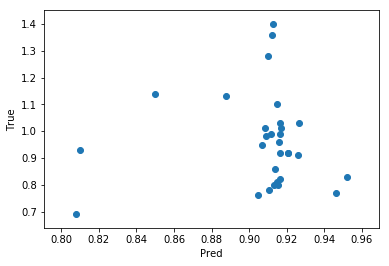

In [19]:
plt.scatter(pred_y_list, true_pred_y_list)
plt.xlabel('Pred')
plt.ylabel('True')

In [20]:
true_pred_y_list

array([0.91, 1.01, 0.92, 0.78, 1.03, 1.4 , 1.28, 0.95, 0.86, 0.99, 0.69,
       0.76, 0.8 , 1.14, 0.82, 1.36, 1.01, 0.81, 0.99, 1.1 , 1.03, 0.98,
       0.8 , 0.96, 1.13, 0.92, 0.83, 0.77, 0.93, 0.92], dtype=float32)

In [21]:
pred_y_list

array([0.926209  , 0.90861654, 0.91659343, 0.9104741 , 0.9266338 ,
       0.91241795, 0.90993685, 0.9070653 , 0.9135395 , 0.91639566,
       0.8080045 , 0.904925  , 0.9130008 , 0.8497    , 0.9161781 ,
       0.9119614 , 0.9168492 , 0.91455543, 0.9114827 , 0.9148986 ,
       0.9163912 , 0.9087175 , 0.91544724, 0.9158325 , 0.8877837 ,
       0.92042434, 0.9519912 , 0.94638747, 0.80976796, 0.92070925],
      dtype=float32)

In [23]:
np.mean(np.square(pred_y_list - true_pred_y_list))

0.032581825